In [1]:
import numpy
import scipy # use numpy if scipy unavailable
import scipy.linalg # use numpy if scipy unavailable

In [3]:
def ransac(data,model,n,k,t,d,debug=False,return_all=False):
    """利用RANSAC算法拟合模型
    
伪代码参考网址
http://en.wikipedia.org/w/index.php?title=RANSAC&oldid=116358182

{{{
输入:
    data - 样本点
    model - 假设可拟合样本点的模型：事先自己确定
    n - 拟合模型所需的最少样本点
    k - 最大迭代次数
    t - 阈值：作为判断点满足模型的条件
    d - 拟合较好时，需要的样本点最少的个数，当作阈值看待
输出:
    bestfit - 最优拟合解（如果未找到，返回nil)
---伪代码：
iterations = 0
bestfit = nil   # 假设模型，后面更新
besterr = something really large   # 后期更新bestrr = thiserr
while iterations < k {
    maybeinliers = n randomly selected values from data   # 从样本中随机选取n个点，不一定全是局内点，甚至全部为局外点
    maybemodel = model parameters fitted to maybeinliers  # 拟合出来的可能符合要求的模型
    alsoinliers = empty set  # 满足误差要求的样本点，一开始置空（在for操作中加入满足要求的点）
    # for(于每一个不是maybeinliers的样本点)
    for every point in data not in maybeinliers {
        if point fits maybemodel with an error smaller than t     #如果满足可能的模型，即误差小于t
             add point to alsoinliers          # 将点加入alsoinliers
    }
    #如果满足误差要求的样本点数目>d
    if the number of elements in alsoinliers is > d {
        % this implies that we may have found a good model   # 有了较好的模型，测试模型符合度
        % now test how good it is
        # 利用所有的从样本中随机选出来的n个点和满足误差要求的样本点重新生成更好的模型
        bettermodel = model parameters fitted to all points in maybeinliers and alsoinliers
        # thiserr为所有的 maybeinliers和alsoinliers样本点的误差度量
        thiserr = a measure of how well model fits these points
        if thiserr < besterr {
            bestfit = bettermodel
            besterr = thiserr
        }
    }
    increment iterations
}
return bestfit
}}}
"""
    iterations = 0
    bestfit = None
    besterr = numpy.inf   #设置初始值为无穷数，后面更新为thiserr
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n,data.shape[0])   # random_partition随机分区
        maybeinliers = data[maybe_idxs,:]   # 获取data中(maybe_idxs)的行数据(Xi,Yi)，设为可能是内点的数据点
        test_points = data[test_idxs]
        maybemodel = model.fit(maybeinliers)  # 拟合模型
        test_err = model.get_error( test_points, maybemodel)  # 用平方和最小计算误差
        also_idxs = test_idxs[test_err < t] # 选择小于误差的点加入alsoinliers
        alsoinliers = data[also_idxs,:]
        if debug:
            print('test_err.min()',test_err.min())
            print('test_err.max()',test_err.max())
            print('numpy.mean(test_err)',numpy.mean(test_err))
            print('iteration %d:len(alsoinliers) = %d'%(iterations,len(alsoinliers)))
        if len(alsoinliers) > d:
            betterdata = numpy.concatenate( (maybeinliers, alsoinliers) )   # 将假设的内点和小于误差的点都进入内点集
            bettermodel = model.fit(betterdata)   # 重新拟合模型
            better_errs = model.get_error( betterdata, bettermodel)
            thiserr = numpy.mean( better_errs )   # 平均误差作为新的误差
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = numpy.concatenate( (maybe_idxs, also_idxs) )
        iterations+=1
    if bestfit is None:
        raise ValueError("did not meet fit acceptance criteria")
    if return_all:
        return bestfit, {'inliers':best_inlier_idxs}
    else:
        return bestfit

def random_partition(n,n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = numpy.arange( n_data )   # 获取n_data下班索引
    numpy.random.shuffle(all_idxs)   # 打乱下标索引
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

class LinearLeastSquaresModel:
    """利用最小二乘法求解线性模型

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.
    
    """
    def __init__(self,input_columns,output_columns,debug=False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
    def fit(self, data):
        A = numpy.vstack([data[:,i] for i in self.input_columns]).T
        B = numpy.vstack([data[:,i] for i in self.output_columns]).T
        x,resids,rank,s = scipy.linalg.lstsq(A,B)   # residues:残差和
        return x   # 返回最小平方和向量
    def get_error( self, data, model):
        A = numpy.vstack([data[:,i] for i in self.input_columns]).T
        B = numpy.vstack([data[:,i] for i in self.output_columns]).T
        B_fit = scipy.dot(A,model)  # 计算的y值,B_fit = model.k*A + model.b
        err_per_point = numpy.sum((B-B_fit)**2,axis=1) # sum squared error per row
        return err_per_point
        
def test():
    # generate perfect input data

    n_samples = 500 # 样本个数
    n_inputs = 1 # 输入变量个数，即x
    n_outputs = 1  # 输出变量个数，即y
    A_exact = 20*numpy.random.random((n_samples,n_inputs) )  # 随机生成0-20之间的500个数据的行向量：x坐标
    perfect_fit = 60*numpy.random.normal(size=(n_inputs,n_outputs) ) # 随机线性度即随机生成一个斜率
    B_exact = scipy.dot(A_exact,perfect_fit)  # y = x * k  ，y
    assert B_exact.shape == (n_samples,n_outputs)  # 验证y坐标数组的大小

    # 加入一些高斯噪声 (最小二乘可以很好的处理)
    A_noisy = A_exact + numpy.random.normal(size=A_exact.shape )  # x坐标添加高斯噪声
    B_noisy = B_exact + numpy.random.normal(size=B_exact.shape )  # y坐标添加高斯噪声

    if 1:
        # 添加“局外点”
        n_outliers = 100   # 500个数据点有100个是局外点
        all_idxs = numpy.arange( A_noisy.shape[0] )  # 获取索引0-499
        numpy.random.shuffle(all_idxs)  # 将索引随机排列
        outlier_idxs = all_idxs[:n_outliers]  # 选取all_idxs前100个做outlier_idxs
        non_outlier_idxs = all_idxs[n_outliers:]  # 后面的不是outlier_idxs
        A_noisy[outlier_idxs] =  20*numpy.random.random((n_outliers,n_inputs) )   # 局外点的Xi
        B_noisy[outlier_idxs] = 50*numpy.random.normal(size=(n_outliers,n_outputs) )  # 局外点的Yi

    # setup model

    all_data = numpy.hstack( (A_noisy,B_noisy) )   # 形式([Xi,Yi]....) shape:(500,2)500行2列，组成坐标对
    input_columns = range(n_inputs) # 数组的第一列x:0
    output_columns = [n_inputs+i for i in range(n_outputs)] # 数组最后一列y
    debug = False
    model = LinearLeastSquaresModel(input_columns,output_columns,debug=debug)  # 类的实例化:用最小二乘生成已知模型

    linear_fit,resids,rank,s = scipy.linalg.lstsq(all_data[:,input_columns],
                                                  all_data[:,output_columns])

    # run RANSAC algorithm
    ransac_fit, ransac_data = ransac(all_data,model,
                                     50, 1000, 7e3, 300, # misc. parameters
                                     debug=debug,return_all=True)
    if 1:
        import pylab

        sort_idxs = numpy.argsort(A_exact[:,0])  # 对A_exact排序， sort_idxs为排序索引
        A_col0_sorted = A_exact[sort_idxs] # 秩为2的数组

        if 1:
            pylab.plot( A_noisy[:,0], B_noisy[:,0], 'k.', label='data' )  # 散点图
            pylab.plot( A_noisy[ransac_data['inliers'],0], B_noisy[ransac_data['inliers'],0], 'bx', label='RANSAC data' )
        else:
            pylab.plot( A_noisy[non_outlier_idxs,0], B_noisy[non_outlier_idxs,0], 'k.', label='noisy data' )
            pylab.plot( A_noisy[outlier_idxs,0], B_noisy[outlier_idxs,0], 'r.', label='outlier data' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,ransac_fit)[:,0],
                    label='RANSAC fit' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,perfect_fit)[:,0],
                    label='exact system' )
        pylab.plot( A_col0_sorted[:,0],
                    numpy.dot(A_col0_sorted,linear_fit)[:,0],
                    label='linear fit' )
        pylab.legend()
        pylab.show()

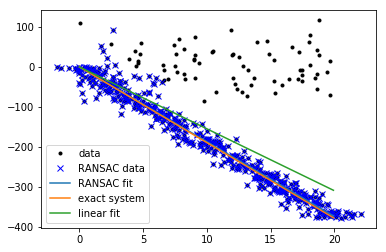

In [5]:
if __name__=='__main__':
    test()